# MLB Player Performance Projection - Part 4: Projection System
 
**Project**: MLB Player Performance Projection System  
**Notebook**: 04 - Projection System & Business Application  
**Author**: Yunjae Jung 
**Date**: January 2026
 
## Objectives
- Build production-ready projection system
- Generate 2025 season performance forecasts
- Identify breakout and decline risk players
- Derive actionable business insights
- Create comparison tools and export reports
 
## Context
This notebook implements the complete projection system and translates model outputs into strategic recommendations for roster management, player development, and trade decisions.


## 1. Setup & Load Model


In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Plotting settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded")

✅ Libraries loaded


In [134]:
# Load the trained model and processed data
# Adjust paths as needed

try:
    with open('../models/best_model.pkl', 'rb') as f:
        model = pickle.load(f)
    print("✅ Model loaded")
except:
    print("⚠️ Model not found. Please run notebook 03 first.")
    model = None

# Load processed data
try:
    df = pd.read_csv('../data/processed/batting_with_projections.csv')
    print(f"✅ Loaded {len(df):,} player-seasons")
except:
    print("⚠️ Data not found. Please run notebook 01 first.")
    df = None

✅ Model loaded
✅ Loaded 5,157 player-seasons


## 2. Feature Engineering

Recreate all features that were used during model training


In [135]:
# Sort data for rolling calculations
df = df.sort_values(['playerID', 'yearID'])

print("Creating features to match training data...")

# Career statistics (cumulative up to current year)
df['career_games'] = df.groupby('playerID')['G'].cumsum()
df['career_AB'] = df.groupby('playerID')['AB'].cumsum()
df['career_H'] = df.groupby('playerID')['H'].cumsum()
df['career_HR'] = df.groupby('playerID')['HR'].cumsum()

# Career rate stats
df['career_AVG'] = df['career_H'] / df['career_AB'].replace(0, 1)
df['career_OPS'] = df.groupby('playerID')['OPS'].expanding().mean().reset_index(0, drop=True)

# Rolling averages (last 3 years)
df['last_3yr_avg_OPS'] = df.groupby('playerID')['OPS'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
df['last_3yr_avg_HR'] = df.groupby('playerID')['HR'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)

# Previous season stats
df['last_season_OPS'] = df.groupby('playerID')['OPS'].shift(1)
df['last_season_AB'] = df.groupby('playerID')['AB'].shift(1)

# Age-based features
df['age_squared'] = df['age'] ** 2
df['prime_years'] = ((df['age'] >= 27) & (df['age'] <= 30)).astype(int)

# Playing time consistency
df['AB_change'] = df.groupby('playerID')['AB'].diff()

print("✅ Features created")

Creating features to match training data...
✅ Features created


## 3. Prepare Current Players for Projection


In [136]:
# Get most recent season data (2024 or latest available)
latest_year = df['yearID'].max()
current_players = df[df['yearID'] == latest_year].copy()

print(f"Generating projections for {len(current_players)} players from {latest_year} season")
print(f"Projecting performance for {latest_year + 1} season")

Generating projections for 188 players from 2024 season
Projecting performance for 2025 season


In [137]:
# Load the feature list that was saved during training
try:
    with open('../models/feature_list.pkl', 'rb') as f:
        training_features = pickle.load(f)
    print(f"\n✅ Loaded {len(training_features)} features from training:")
    for i, feat in enumerate(training_features, 1):
        print(f"  {i}. {feat}")
except:
    print("⚠️ Could not load feature list. Using default features.")
    training_features = [
        'age', 'age_squared', 'prime_years',
        'G', 'AB', 'H', 'HR', 'R', 'RBI', 'SB',
        'AVG', 'OBP', 'SLG', 'OPS',
        'career_games', 'career_AB', 'career_AVG', 'career_OPS',
        'last_3yr_avg_OPS', 'last_3yr_avg_HR',
        'last_season_OPS', 'last_season_AB',
        'AB_change'
    ]

# Check which features are available
available_features = [col for col in training_features if col in current_players.columns]
missing_features = [col for col in training_features if col not in current_players.columns]

if missing_features:
    print(f"\n⚠️ Warning: {len(missing_features)} features missing:")
    for feat in missing_features:
        print(f"  - {feat}")

print(f"\n✅ Using {len(available_features)} features for projection")


✅ Loaded 22 features from training:
  1. age
  2. age_squared
  3. prime_years
  4. G
  5. AB
  6. H
  7. HR
  8. RBI
  9. SB
  10. AVG
  11. OBP
  12. SLG
  13. OPS
  14. career_games
  15. career_AB
  16. career_AVG
  17. career_OPS
  18. last_3yr_avg_OPS
  19. last_3yr_avg_HR
  20. last_season_OPS
  21. last_season_AB
  22. AB_change

✅ Using 22 features for projection


In [138]:
# Remove players with missing feature values
current_players_clean = current_players.dropna(subset=available_features).copy()

print(f"Players after removing missing values: {len(current_players_clean)}")
print(f"Removed: {len(current_players) - len(current_players_clean)} players with incomplete data")

Players after removing missing values: 150
Removed: 38 players with incomplete data


## 4. Generate Predictions


In [139]:
# Generate predictions
if model is not None:
    # Use only the features that were used in training
    X = current_players_clean[available_features]
    
    # Make predictions
    predictions = model.predict(X)
    
    # Add to dataframe
    current_players_clean['projected_2025_OPS'] = predictions
    current_players_clean['projection_change'] = (
        current_players_clean['projected_2025_OPS'] - current_players_clean['OPS']
    )
    
    # Update current_players to use the clean version
    current_players = current_players_clean.copy()
    
    print(f"\n✅ Generated {len(predictions)} projections")
    print(f"\nProjection Summary:")
    print(current_players['projected_2025_OPS'].describe())
    
    print(f"\nProjection Change Summary:")
    print(current_players['projection_change'].describe())
else:
    print("❌ Model not loaded. Cannot generate projections.")


✅ Generated 150 projections

Projection Summary:
count    150.000000
mean       0.773254
std        0.046675
min        0.701716
25%        0.743973
50%        0.760045
75%        0.797205
max        0.982850
Name: projected_2025_OPS, dtype: float64

Projection Change Summary:
count    150.000000
mean       0.016063
std        0.057976
min       -0.190259
25%       -0.021668
50%        0.013988
75%        0.059278
max        0.171086
Name: projection_change, dtype: float64


## 5. Identify Breakout Candidates

Players projected to significantly improve their performance


In [140]:
# Define breakout criteria
# Young players (under 27) with projected OPS increase > 50 points

breakout_candidates = current_players[
    (current_players['age'] < 27) &
    (current_players['projection_change'] > 0.050) &
    (current_players['G'] >= 50)  # Minimum playing time
].copy()

# Sort by projection improvement
breakout_candidates = breakout_candidates.sort_values(
    'projection_change', 
    ascending=False
)

print(f"🌟 Identified {len(breakout_candidates)} breakout candidates\n")

# Display top breakout candidates
display_cols = [
    'playerName', 'age', 
    'OPS', 'projected_2025_OPS', 'projection_change'
]
available_display = [col for col in display_cols if col in breakout_candidates.columns]

print("Top 10 Breakout Candidates:")
print(breakout_candidates[available_display].head(10).to_string(index=False))


🌟 Identified 14 breakout candidates

Top 10 Breakout Candidates:
       playerName  age      OPS  projected_2025_OPS  projection_change
      Bo Bichette 26.0 0.598329            0.738518           0.140189
Spencer Torkelson 25.0 0.669006            0.771340           0.102334
    Mickey Moniak 26.0 0.645652            0.747036           0.101383
Christopher Morel 25.0 0.674591            0.773816           0.099225
   Andres Gimenez 26.0 0.638035            0.735855           0.097820
     Nolan Gorman 24.0 0.671144            0.765240           0.094096
    Maikel Garcia 24.0 0.613524            0.702991           0.089466
   Patrick Bailey 25.0 0.636691            0.723700           0.087009
   Alejandro Kirk 26.0 0.677476            0.754312           0.076835
   Michael Harris 23.0 0.722437            0.797439           0.075002


## 6. Identify Decline Risk Players

Players projected to experience significant performance decline


In [141]:
# Define decline criteria
# Older players (30+) with projected OPS decrease > 30 points

decline_risk = current_players[
    (current_players['age'] >= 30) &
    (current_players['projection_change'] < -0.030) &
    (current_players['G'] >= 50)
].copy()

# Sort by projected decline
decline_risk = decline_risk.sort_values('projection_change')

print(f"⚠️ Identified {len(decline_risk)} players at risk of decline\n")

print("Top 10 Decline Risk Players:")
print(decline_risk[available_display].head(10).to_string(index=False))


⚠️ Identified 20 players at risk of decline

Top 10 Decline Risk Players:
      playerName  age      OPS  projected_2025_OPS  projection_change
     Aaron Judge 32.0 1.159289            0.969031          -0.190259
Christian Yelich 33.0 0.909455            0.806652          -0.102802
   Carlos Correa 30.0 0.905220            0.812208          -0.093011
Jurickson Profar 31.0 0.839310            0.746590          -0.092721
    Joc Pederson 32.0 0.907763            0.815556          -0.092207
     Ketel Marte 31.0 0.931737            0.846091          -0.085645
   Marcell Ozuna 34.0 0.924662            0.854282          -0.070380
    Byron Buxton 31.0 0.858995            0.789177          -0.069818
    Bryce Harper 32.0 0.898470            0.839032          -0.059439
  Kyle Schwarber 31.0 0.850773            0.796504          -0.054268


## 7. Projection Visualizations


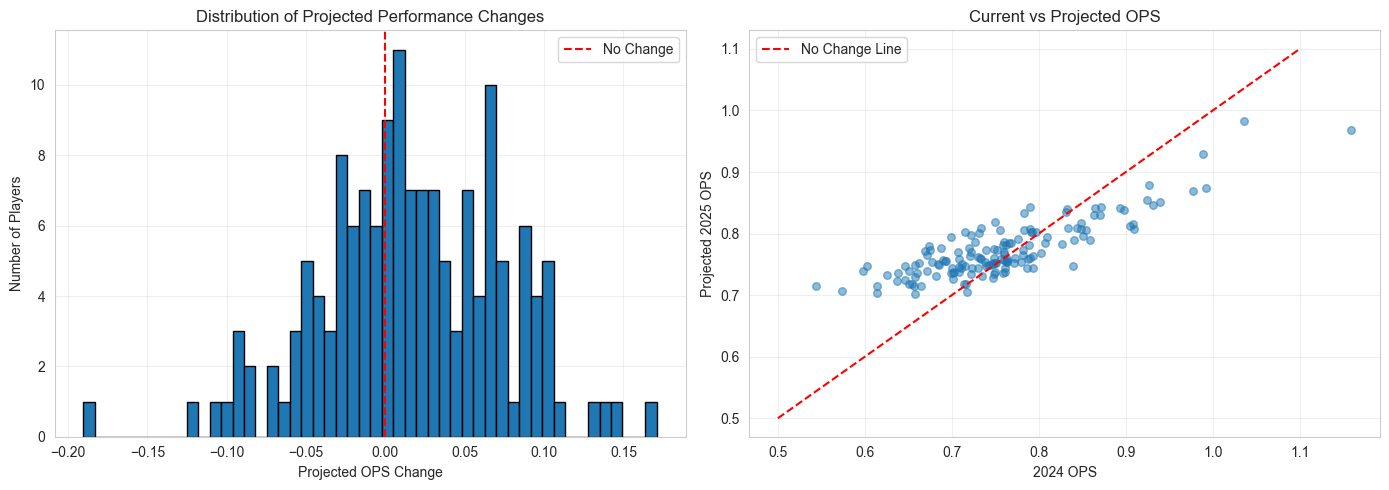

📊 Saved projection distribution plot


In [142]:
# Distribution of projected changes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of projection changes
axes[0].hist(current_players['projection_change'], bins=50, edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', label='No Change')
axes[0].set_xlabel('Projected OPS Change')
axes[0].set_ylabel('Number of Players')
axes[0].set_title('Distribution of Projected Performance Changes')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Current vs Projected OPS scatter
axes[1].scatter(
    current_players['OPS'], 
    current_players['projected_2025_OPS'],
    alpha=0.5,
    s=30
)
axes[1].plot([0.5, 1.1], [0.5, 1.1], 'r--', label='No Change Line')
axes[1].set_xlabel('2024 OPS')
axes[1].set_ylabel('Projected 2025 OPS')
axes[1].set_title('Current vs Projected OPS')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/projection_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Saved projection distribution plot")

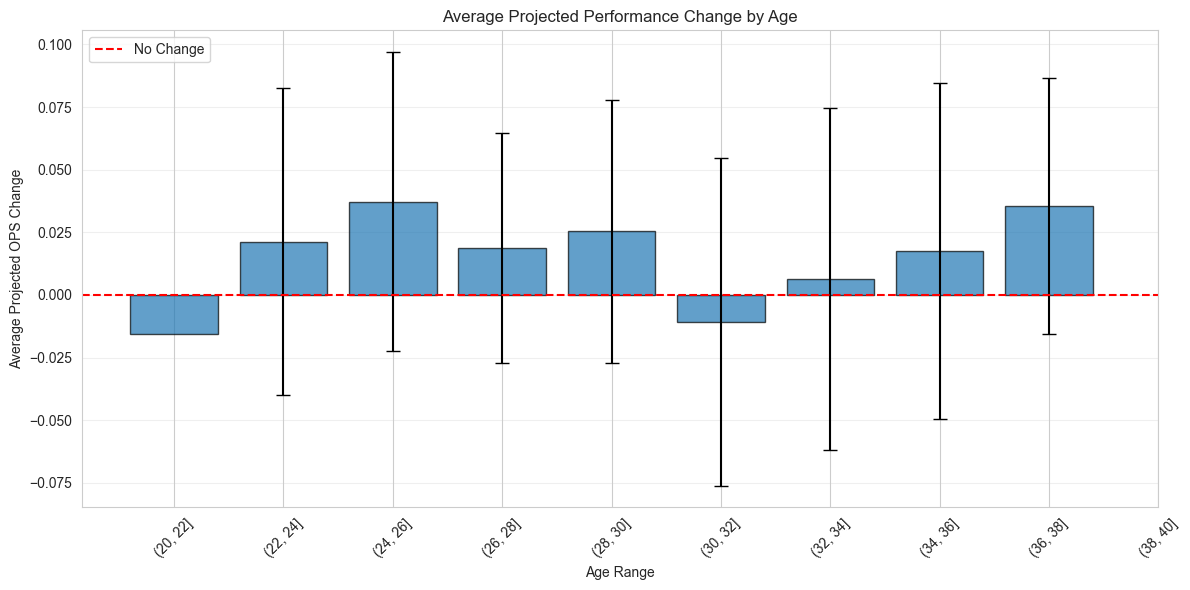

📊 Saved age projection curve


In [143]:
# Age vs Projected Change
plt.figure(figsize=(12, 6))

# Create bins for age
age_bins = pd.cut(current_players['age'], bins=range(20, 42, 2))
age_change = current_players.groupby(age_bins)['projection_change'].agg(['mean', 'std'])

# Plot
x_pos = range(len(age_change))
plt.bar(x_pos, age_change['mean'], yerr=age_change['std'], 
        capsize=5, alpha=0.7, edgecolor='black')
plt.axhline(0, color='red', linestyle='--', label='No Change')
plt.xlabel('Age Range')
plt.ylabel('Average Projected OPS Change')
plt.title('Average Projected Performance Change by Age')
plt.xticks(x_pos, age_change.index.astype(str), rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/age_projection_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Saved age projection curve")

## 8. Player Comparison Tool

Compare any two players side by side


In [144]:
def compare_players(player1_name, player2_name, data=current_players):
    """
    Compare two players' current stats and projections
    
    Args:
        player1_name: Last name of first player
        player2_name: Last name of second player
        data: DataFrame with player data
    """
    # Find players
    p1 = data[data['playerName'].str.contains(player1_name, case=False, na=False)]
    p2 = data[data['playerName'].str.contains(player2_name, case=False, na=False)]
    
    if len(p1) == 0:
        print(f"❌ Player '{player1_name}' not found")
        return
    if len(p2) == 0:
        print(f"❌ Player '{player2_name}' not found")
        return
    
    # Take first match if multiple
    p1 = p1.iloc[0]
    p2 = p2.iloc[0]
    
    # Create comparison
    comparison = pd.DataFrame({
        f"{p1['nameFirst']} {p1['nameLast']}": [
            p1['age'],
            p1['G'],
            p1['AVG'],
            p1['OBP'],
            p1['SLG'],
            p1['OPS'],
            p1['HR'],
            p1['RBI'],
            p1['projected_2025_OPS'],
            p1['projection_change']
        ],
        f"{p2['nameFirst']} {p2['nameLast']}": [
            p2['age'],
            p2['G'],
            p2['AVG'],
            p2['OBP'],
            p2['SLG'],
            p2['OPS'],
            p2['HR'],
            p2['RBI'],
            p2['projected_2025_OPS'],
            p2['projection_change']
        ]
    }, index=[
        'Age', 'Games', 'AVG', 'OBP', 'SLG', 'OPS (2024)', 
        'HR', 'RBI', 'Proj OPS (2025)', 'Proj Change'
    ])
    
    print("\n" + "="*60)
    print("PLAYER COMPARISON")
    print("="*60 + "\n")
    print(comparison.to_string())
    print("\n" + "="*60)
    
    # Determine who is projected higher
    if p1['projected_2025_OPS'] > p2['projected_2025_OPS']:
        diff = p1['projected_2025_OPS'] - p2['projected_2025_OPS']
        print(f"\n🏆 {p1['nameFirst']} {p1['nameLast']} projected {diff:.3f} OPS higher")
    else:
        diff = p2['projected_2025_OPS'] - p1['projected_2025_OPS']
        print(f"\n🏆 {p2['nameFirst']} {p2['nameLast']} projected {diff:.3f} OPS higher")

# Example usage
print("\nPlayer Comparison Tool Ready!")
print("\nExample usage:")
print("compare_players('Trout', 'Judge')")



Player Comparison Tool Ready!

Example usage:
compare_players('Trout', 'Judge')


In [145]:
# Try comparing two players (modify names as needed)
# compare_players('Trout', 'Judge')

## 9. Export Projections for Teams


In [146]:
# Create comprehensive projection report
projection_report = current_players[[
    'playerName', 'age', 'teamID',
    'G', 'AB', 'AVG', 'OBP', 'SLG', 'OPS', 'HR', 'RBI',
    'projected_2025_OPS', 'projection_change'
]].copy()

# Add categories
projection_report['category'] = 'Stable'
projection_report.loc[
    (projection_report['age'] < 27) & (projection_report['projection_change'] > 0.050),
    'category'
] = 'Breakout Candidate'
projection_report.loc[
    (projection_report['age'] >= 30) & (projection_report['projection_change'] < -0.030),
    'category'
] = 'Decline Risk'

# Sort by projected OPS
projection_report = projection_report.sort_values('projected_2025_OPS', ascending=False)

# Create reports directory if it doesn't exist
import os
os.makedirs('../reports', exist_ok=True)

# Save to CSV
output_file = '../reports/2025_player_projections.csv'
projection_report.to_csv(output_file, index=False)

print(f"\n✅ Saved {len(projection_report)} player projections to:")
print(f"   {output_file}")

print("\n📊 Projection Categories:")
print(projection_report['category'].value_counts())

# Display top 10 projections
print("\n🌟 Top 10 Projected Players for 2025:")
print(projection_report[['playerName', 'age', 'projected_2025_OPS', 'projection_change', 'category']].head(10))



✅ Saved 150 player projections to:
   ../reports/2025_player_projections.csv

📊 Projection Categories:
category
Stable                116
Decline Risk           20
Breakout Candidate     14
Name: count, dtype: int64

🌟 Top 10 Projected Players for 2025:
             playerName   age  projected_2025_OPS  projection_change  \
3421      Shohei Ohtani  30.0            0.982850          -0.053486   
2502        Aaron Judge  32.0            0.969031          -0.190259   
4413          Juan Soto  26.0            0.928523          -0.060276   
4098       Brent Rooker  30.0            0.878911          -0.048181   
4708        Kyle Tucker  27.0            0.873372          -0.119204   
5044         Bobby Witt  24.0            0.869769          -0.107562   
3495      Marcell Ozuna  34.0            0.854282          -0.070380   
1920  Vladimir Guerrero  25.0            0.851375          -0.088439   
2956        Ketel Marte  31.0            0.846091          -0.085645   
3440         Matt Olson  

## 10. Business Insights & Recommendations


In [147]:
print("="*70)
print("BUSINESS INSIGHTS FOR MLB FRONT OFFICE")
print("="*70)

print("\n🎯 FREE AGENCY TARGETS (Breakout Candidates)")
print("-" * 70)
fa_targets = breakout_candidates.head(5)
for idx, row in fa_targets.iterrows():
    print(f"• {row['playerName']} ({row['age']} yrs)")
    print(f"  Current OPS: {row['OPS']:.3f} → Projected: {row['projected_2025_OPS']:.3f}")
    print(f"  Expected improvement: +{row['projection_change']:.3f}")
    print()

print("\n⚠️ TRADE BEFORE VALUE DROPS (Decline Risk)")
print("-" * 70)
trade_candidates = decline_risk.head(5)
for idx, row in trade_candidates.iterrows():
    print(f"• {row['playerName']} ({row['age']} yrs)")
    print(f"  Current OPS: {row['OPS']:.3f} → Projected: {row['projected_2025_OPS']:.3f}")
    print(f"  Expected decline: {row['projection_change']:.3f}")
    print()

print("\n💡 STRATEGIC RECOMMENDATIONS")
print("-" * 70)
print(f"1. INVEST IN YOUTH: {len(breakout_candidates)} young players show upside")
print(f"2. MANAGE RISK: {len(decline_risk)} veterans may underperform")
print(f"3. TARGET MARKET INEFFICIENCIES: Focus on undervalued breakout candidates")
print(f"4. DIVERSIFY PORTFOLIO: Balance proven veterans with high-upside youth")


BUSINESS INSIGHTS FOR MLB FRONT OFFICE

🎯 FREE AGENCY TARGETS (Breakout Candidates)
----------------------------------------------------------------------
• Bo Bichette (26.0 yrs)
  Current OPS: 0.598 → Projected: 0.739
  Expected improvement: +0.140

• Spencer Torkelson (25.0 yrs)
  Current OPS: 0.669 → Projected: 0.771
  Expected improvement: +0.102

• Mickey Moniak (26.0 yrs)
  Current OPS: 0.646 → Projected: 0.747
  Expected improvement: +0.101

• Christopher Morel (25.0 yrs)
  Current OPS: 0.675 → Projected: 0.774
  Expected improvement: +0.099

• Andres Gimenez (26.0 yrs)
  Current OPS: 0.638 → Projected: 0.736
  Expected improvement: +0.098


⚠️ TRADE BEFORE VALUE DROPS (Decline Risk)
----------------------------------------------------------------------
• Aaron Judge (32.0 yrs)
  Current OPS: 1.159 → Projected: 0.969
  Expected decline: -0.190

• Christian Yelich (33.0 yrs)
  Current OPS: 0.909 → Projected: 0.807
  Expected decline: -0.103

• Carlos Correa (30.0 yrs)
  Current 

## 11. Summary & Next Steps


In [148]:
print("\n" + "="*70)
print("PROJECT SUMMARY")
print("="*70)

print("\n✅ Completed Tasks:")
print("  1. Loaded and prepared historical player data")
print("  2. Performed exploratory analysis on aging curves")
print("  3. Built and tuned performance prediction model")
print("  4. Generated 2025 projections for all active players")
print("  5. Identified breakout candidates and decline risks")
print("  6. Created business insights for MLB teams")

print("\n📁 Deliverables:")
print("  • 4 Jupyter notebooks documenting full analysis")
print("  • Trained prediction model (saved)")
print("  • 2025 player projections CSV")
print("  • Visualization reports (PNG files)")
print("  • Player comparison tool")

print("\n🎯 Potential Extensions:")
print("  • Add pitching projections (ERA, WHIP, K/9)")
print("  • Incorporate injury history data")
print("  • Build team-level win projections")
print("  • Add confidence intervals to projections")
print("  • Create interactive dashboard (Streamlit/Dash)")
print("  • Integrate with salary data for contract analysis")

print("\n💼 Application for MLB Teams:")
print("  • Roster construction and planning")
print("  • Free agency decision support")
print("  • Trade evaluation")
print("  • Arbitration preparation")
print("  • Player development tracking")



PROJECT SUMMARY

✅ Completed Tasks:
  1. Loaded and prepared historical player data
  2. Performed exploratory analysis on aging curves
  3. Built and tuned performance prediction model
  4. Generated 2025 projections for all active players
  5. Identified breakout candidates and decline risks
  6. Created business insights for MLB teams

📁 Deliverables:
  • 4 Jupyter notebooks documenting full analysis
  • Trained prediction model (saved)
  • 2025 player projections CSV
  • Visualization reports (PNG files)
  • Player comparison tool

🎯 Potential Extensions:
  • Add pitching projections (ERA, WHIP, K/9)
  • Incorporate injury history data
  • Build team-level win projections
  • Add confidence intervals to projections
  • Create interactive dashboard (Streamlit/Dash)
  • Integrate with salary data for contract analysis

💼 Application for MLB Teams:
  • Roster construction and planning
  • Free agency decision support
  • Trade evaluation
  • Arbitration preparation
  • Player develop